# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [13]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [14]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [15]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "apolanco3225"
kaggle_key = "bca60f3f8b9c1ef91697003576f7c48a"
#kaggle_username = "FILL_IN_USERNAME"
#kaggle_key = "FILL_IN_KEY"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [16]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open bike-sharing-demand.zip, bike-sharing-demand.zip.zip or bike-sharing-demand.zip.ZIP.


In [17]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [18]:
!ls

sample_data  sampleSubmission.csv  test.csv  train.csv


In [19]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [20]:
print(train.shape)
print(train.columns)

(10886, 12)
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


In [21]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [22]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [23]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [24]:
predictor = TabularPredictor(
    label="count",
    problem_type="regression",
    eval_metric="r2",
    learner_kwargs={"ignored_columns": ["casual", "registered"]}

    )

predictor.fit(
    train_data=train,
    time_limit=600, 
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220130_135648/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220130_135648/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 11
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12577.15 MB
	Train Data (Original)  Memory Usage: 1.52 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatur

[1000]	train_set's l2: 15328	train_set's r2: 0.533746	valid_set's l2: 18055	valid_set's r2: 0.439332
[2000]	train_set's l2: 13785.7	train_set's r2: 0.58068	valid_set's l2: 17877.1	valid_set's r2: 0.444915


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 15232.6	train_set's r2: 0.530585	valid_set's l2: 20022.3	valid_set's r2: 0.443843


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 15649.3	train_set's r2: 0.522702	valid_set's l2: 16588.6	valid_set's r2: 0.497026
[2000]	train_set's l2: 14161.7	train_set's r2: 0.568098	valid_set's l2: 16360.6	valid_set's r2: 0.504036
[3000]	train_set's l2: 13140	train_set's r2: 0.599224	valid_set's l2: 16238.8	valid_set's r2: 0.507662
[4000]	train_set's l2: 12386.5	train_set's r2: 0.622208	valid_set's l2: 16114.5	valid_set's r2: 0.511552
[5000]	train_set's l2: 11788.7	train_set's r2: 0.64045	valid_set's l2: 16089.4	valid_set's r2: 0.512179
[6000]	train_set's l2: 11254	train_set's r2: 0.656801	valid_set's l2: 16055.4	valid_set's r2: 0.513193


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 15408.5	train_set's r2: 0.524138	valid_set's l2: 19127.7	valid_set's r2: 0.478402
[2000]	train_set's l2: 13884.7	train_set's r2: 0.571151	valid_set's l2: 18915.8	valid_set's r2: 0.484176
[3000]	train_set's l2: 12867	train_set's r2: 0.602611	valid_set's l2: 18877.5	valid_set's r2: 0.485291
[4000]	train_set's l2: 12068.7	train_set's r2: 0.627246	valid_set's l2: 18830.4	valid_set's r2: 0.486634


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 15592.8	train_set's r2: 0.529687	valid_set's l2: 16397.2	valid_set's r2: 0.445521
[2000]	train_set's l2: 14053.4	train_set's r2: 0.576101	valid_set's l2: 16129.9	valid_set's r2: 0.454513
[3000]	train_set's l2: 13024.3	train_set's r2: 0.607119	valid_set's l2: 16086.8	valid_set's r2: 0.455967
[4000]	train_set's l2: 12242.3	train_set's r2: 0.630736	valid_set's l2: 16051.3	valid_set's r2: 0.4571


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 15538.6	train_set's r2: 0.52874	valid_set's l2: 18250.6	valid_set's r2: 0.418188
[2000]	train_set's l2: 14104.9	train_set's r2: 0.57219	valid_set's l2: 17915.6	valid_set's r2: 0.428875
[3000]	train_set's l2: 13136.5	train_set's r2: 0.601614	valid_set's l2: 17824.7	valid_set's r2: 0.431713
[4000]	train_set's l2: 12376.4	train_set's r2: 0.624628	valid_set's l2: 17814.8	valid_set's r2: 0.43196
[5000]	train_set's l2: 11762.6	train_set's r2: 0.643258	valid_set's l2: 17763.7	valid_set's r2: 0.433671


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 15378.5	train_set's r2: 0.532816	valid_set's l2: 19419.7	valid_set's r2: 0.390061
[2000]	train_set's l2: 13881.3	train_set's r2: 0.5783	valid_set's l2: 19130.3	valid_set's r2: 0.398951
[3000]	train_set's l2: 12859.5	train_set's r2: 0.609322	valid_set's l2: 19012.7	valid_set's r2: 0.402681
[4000]	train_set's l2: 12107	train_set's r2: 0.632211	valid_set's l2: 18977.2	valid_set's r2: 0.403808


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 15492.8	train_set's r2: 0.526852	valid_set's l2: 18336.5	valid_set's r2: 0.451093


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 15420.6	train_set's r2: 0.530818	valid_set's l2: 18927.9	valid_set's r2: 0.413354
[2000]	train_set's l2: 13872.7	train_set's r2: 0.577949	valid_set's l2: 18676.9	valid_set's r2: 0.421144
[3000]	train_set's l2: 12870.3	train_set's r2: 0.608454	valid_set's l2: 18562.8	valid_set's r2: 0.424758
[4000]	train_set's l2: 12096	train_set's r2: 0.631942	valid_set's l2: 18557.7	valid_set's r2: 0.424816


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 15535.3	train_set's r2: 0.528587	valid_set's l2: 17552	valid_set's r2: 0.441059


	0.4522	 = Validation score   (r2)
	95.63s	 = Training   runtime
	2.38s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 296.1s of the 496.14s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and w

[1000]	train_set's l2: 9220.16	train_set's r2: 0.718792	valid_set's l2: 15190.4	valid_set's r2: 0.53965


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 8977.16	train_set's r2: 0.722756	valid_set's l2: 18396.9	valid_set's r2: 0.498428


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 9083.14	train_set's r2: 0.724494	valid_set's l2: 17447.1	valid_set's r2: 0.443762


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 9056.1	train_set's r2: 0.723412	valid_set's l2: 17297.8	valid_set's r2: 0.482139


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	0.4666	 = Validation score   (r2)
	21.68s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 272.7s of the 472.74s of remaining time.
	0.5723	 = Validation score   (r2)
	6.83s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: CatB

### Review AutoGluon's training run with ranking of models that did the best.

In [25]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.598509       6.538704  509.468904                0.000612           0.330584            3       True         19
1   NeuralNetFastAI_BAG_L2   0.593899       5.714019  444.240492                0.273628          91.522262            2       True         16
2        LightGBMXT_BAG_L2   0.587076       5.624755  365.813236                0.184365          13.095006            2       True         11
3          CatBoost_BAG_L2   0.585677       5.474573  375.503867                0.034183          22.785637            2       True         14
4          LightGBM_BAG_L2   0.583216       5.528720  361.745078                0.088330           9.026848            2       True         12
5           XGBoost_BAG_L2   0.579732       5.501895  366.884341                

{'leaderboard':                      model  score_val  ...  can_infer  fit_order
 0      WeightedEnsemble_L3   0.598509  ...       True         19
 1   NeuralNetFastAI_BAG_L2   0.593899  ...       True         16
 2        LightGBMXT_BAG_L2   0.587076  ...       True         11
 3          CatBoost_BAG_L2   0.585677  ...       True         14
 4          LightGBM_BAG_L2   0.583216  ...       True         12
 5           XGBoost_BAG_L2   0.579732  ...       True         17
 6     ExtraTreesMSE_BAG_L2   0.579066  ...       True         15
 7      WeightedEnsemble_L2   0.572594  ...       True         10
 8   RandomForestMSE_BAG_L1   0.572330  ...       True          5
 9   RandomForestMSE_BAG_L2   0.564994  ...       True         13
 10    ExtraTreesMSE_BAG_L1   0.494906  ...       True          7
 11         LightGBM_BAG_L1   0.466619  ...       True          4
 12          XGBoost_BAG_L1   0.466462  ...       True          8
 13         CatBoost_BAG_L1   0.465713  ...       True       

### Create predictions from test dataset

In [26]:
predictions = predictor.predict(test)
predictions.head()

0     98.512482
1     94.600563
2     94.601921
3    109.429085
4    109.521187
Name: count, dtype: float32

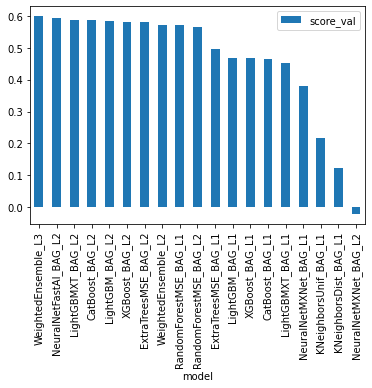

In [27]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [28]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      212.440994
std       129.012054
min       -14.117181
25%       107.309258
50%       195.481766
75%       298.786591
max       661.455750
Name: count, dtype: float64

In [29]:
# How many negative values do we have?
predictions[predictions < 0].shape

(2,)

In [30]:
# Set them to zero
predictions[predictions < 0] = 0
print(predictions[predictions < 0].shape)

(0,)


### Set predictions to submission dataframe, save, and submit

In [31]:
submission["count"] = predictions.values
submission.to_csv("submission.csv", index=False)

In [32]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:00<00:00, 733kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [33]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2022-01-30 14:07:16  first raw submission               complete  1.39725      1.39725       
submission_new_hpo.csv       2022-01-29 22:38:47  new features with hyperparameters  complete  1.22538      1.22538       
submission_new_hpo.csv       2022-01-29 22:03:54  new features with hyperparameters  complete  1.21963      1.21963       


#### Initial score of 1.39725

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

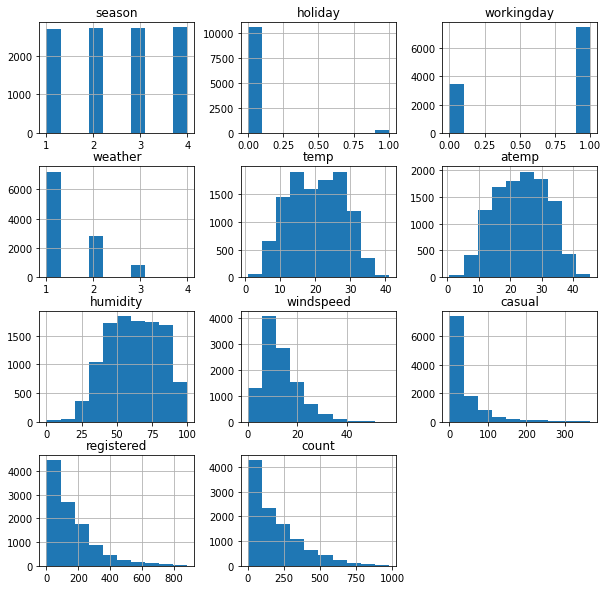

In [34]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(10, 10));

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [35]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [36]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


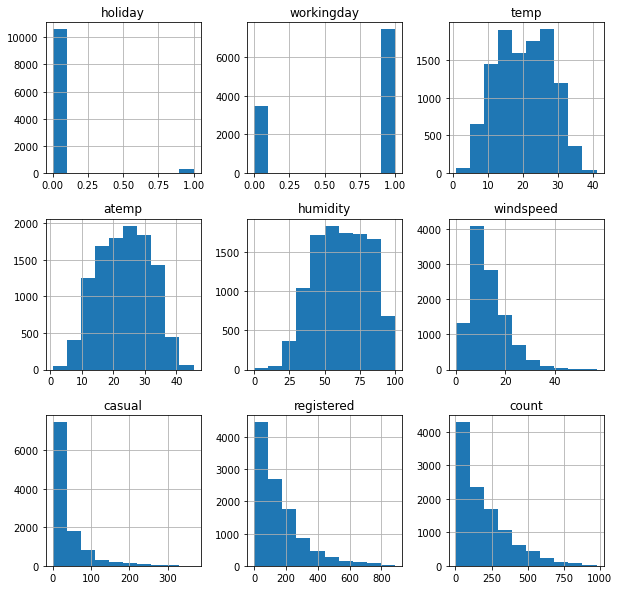

In [37]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(10, 10));

In [38]:
train['datetime'] = pd.to_datetime(train[ 'datetime'])
train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(3), int64(9)
memory usage: 

In [40]:
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test.datetime.dt.year
test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day

In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   category      
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   category      
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
 9   year        6493 non-null   int64         
 10  month       6493 non-null   int64         
 11  day         6493 non-null   int64         
dtypes: category(2), datetime64[ns](1), float64(3), int64(6)
memory usage: 520.4 KB


## Step 5: Rerun the model with the same settings as before, just with more features

In [42]:
predictor_new_features = TabularPredictor(
    label="count",
    problem_type="regression",
    eval_metric="r2",
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
    )

predictor_new_features.fit(
    train_data=train,
    time_limit=600, 
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220130_140721/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220130_140721/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 14
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10092.34 MB
	Train Data (Original)  Memory Usage: 0.89 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatur

[1000]	train_set's l2: 12994.4	train_set's r2: 0.604741	valid_set's l2: 16903.6	valid_set's r2: 0.474939
[2000]	train_set's l2: 10961.6	train_set's r2: 0.666577	valid_set's l2: 16744.1	valid_set's r2: 0.479992


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 13202	train_set's r2: 0.597322	valid_set's l2: 15871.6	valid_set's r2: 0.51881


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 12919.3	train_set's r2: 0.601017	valid_set's l2: 18439.3	valid_set's r2: 0.497203
[2000]	train_set's l2: 10940.8	train_set's r2: 0.662085	valid_set's l2: 17999.8	valid_set's r2: 0.509088
[3000]	train_set's l2: 9702.57	train_set's r2: 0.700301	valid_set's l2: 17923.5	valid_set's r2: 0.511342
[4000]	train_set's l2: 8766.07	train_set's r2: 0.729274	valid_set's l2: 17847.6	valid_set's r2: 0.513316
[5000]	train_set's l2: 8047.73	train_set's r2: 0.751431	valid_set's l2: 17839.1	valid_set's r2: 0.513596


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 13174	train_set's r2: 0.60265	valid_set's l2: 15390.7	valid_set's r2: 0.479478
[2000]	train_set's l2: 11073.4	train_set's r2: 0.666028	valid_set's l2: 15289.9	valid_set's r2: 0.48286


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 13009.3	train_set's r2: 0.60544	valid_set's l2: 17433	valid_set's r2: 0.444285
[2000]	train_set's l2: 10989.5	train_set's r2: 0.666663	valid_set's l2: 17146.3	valid_set's r2: 0.453282
[3000]	train_set's l2: 9716.12	train_set's r2: 0.705309	valid_set's l2: 16974.6	valid_set's r2: 0.4589
[4000]	train_set's l2: 8805.99	train_set's r2: 0.732938	valid_set's l2: 16893.8	valid_set's r2: 0.461496
[5000]	train_set's l2: 8110.15	train_set's r2: 0.754026	valid_set's l2: 16830.2	valid_set's r2: 0.463282


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 12969.8	train_set's r2: 0.606035	valid_set's l2: 18469.4	valid_set's r2: 0.419701
[2000]	train_set's l2: 10971.5	train_set's r2: 0.666696	valid_set's l2: 18078.6	valid_set's r2: 0.432032
[3000]	train_set's l2: 9695.01	train_set's r2: 0.705472	valid_set's l2: 17969.6	valid_set's r2: 0.435517
[4000]	train_set's l2: 8750.12	train_set's r2: 0.734191	valid_set's l2: 17936.6	valid_set's r2: 0.436482


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 13052.4	train_set's r2: 0.601352	valid_set's l2: 17452.1	valid_set's r2: 0.477624
[2000]	train_set's l2: 11014.8	train_set's r2: 0.663629	valid_set's l2: 17192.5	valid_set's r2: 0.485169
[3000]	train_set's l2: 9721.32	train_set's r2: 0.70308	valid_set's l2: 17135.7	valid_set's r2: 0.486992
[4000]	train_set's l2: 8800.3	train_set's r2: 0.73126	valid_set's l2: 17126.6	valid_set's r2: 0.487226


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 12903.7	train_set's r2: 0.607372	valid_set's l2: 18142.1	valid_set's r2: 0.437769
[2000]	train_set's l2: 10874.3	train_set's r2: 0.669102	valid_set's l2: 17967	valid_set's r2: 0.443227
[3000]	train_set's l2: 9603.63	train_set's r2: 0.707764	valid_set's l2: 17972.4	valid_set's r2: 0.442849


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 13061.9	train_set's r2: 0.603645	valid_set's l2: 16864.6	valid_set's r2: 0.462817
[2000]	train_set's l2: 11006.6	train_set's r2: 0.666003	valid_set's l2: 16658.3	valid_set's r2: 0.469484
[3000]	train_set's l2: 9698.62	train_set's r2: 0.705688	valid_set's l2: 16589.4	valid_set's r2: 0.471692
[4000]	train_set's l2: 8789.22	train_set's r2: 0.733262	valid_set's l2: 16503.2	valid_set's r2: 0.474467


	0.4774	 = Validation score   (r2)
	75.53s	 = Training   runtime
	2.43s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 316.52s of the 516.54s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and 

[1000]	train_set's l2: 8133.21	train_set's r2: 0.748816	valid_set's l2: 17877.7	valid_set's r2: 0.512543


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 8215.86	train_set's r2: 0.750792	valid_set's l2: 16752.5	valid_set's r2: 0.465913


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 8218.74	train_set's r2: 0.750319	valid_set's l2: 18041.3	valid_set's r2: 0.433278


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 8317.78	train_set's r2: 0.745974	valid_set's l2: 17158.8	valid_set's r2: 0.486414


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 8188.8	train_set's r2: 0.751522	valid_set's l2: 16628.1	valid_set's r2: 0.470471


	0.4794	 = Validation score   (r2)
	24.79s	 = Training   runtime
	0.6s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 289.64s of the 489.67s of remaining time.
	0.5802	 = Validation score   (r2)
	8.03s	 = Training   runtime
	0.39s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 280.57s of the 480.59s of remaining time.
	0.4657	 = Validation score   (r2)
	113.19s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 167.18s of the 367.2s of remaining time.
	0.5182	 = Validation score   (r2)
	3.42s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 162.77s of the 362.79s of remaining time.
	0.4458	 = Validation score   (r2)
	111.4s	 = Training   runtime
	0.29s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ... Training model for up to 50.86s of the 250.89s of remaining time.
	0.472

In [43]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.604720       7.623524  543.294133                0.000633           0.290681            3       True         19
1   NeuralNetFastAI_BAG_L2   0.601207       6.771175  471.503715                0.330311          88.570783            2       True         17
2        LightGBMXT_BAG_L2   0.592645       6.656117  396.306286                0.215253          13.373355            2       True         12
3          CatBoost_BAG_L2   0.592449       6.497554  424.304875                0.056690          41.371943            2       True         15
4          LightGBM_BAG_L2   0.589916       6.560277  392.659570                0.119412           9.726638            2       True         13
5     ExtraTreesMSE_BAG_L2   0.585967       6.901225  389.960733                

{'leaderboard':                      model  score_val  ...  can_infer  fit_order
 0      WeightedEnsemble_L3   0.604720  ...       True         19
 1   NeuralNetFastAI_BAG_L2   0.601207  ...       True         17
 2        LightGBMXT_BAG_L2   0.592645  ...       True         12
 3          CatBoost_BAG_L2   0.592449  ...       True         15
 4          LightGBM_BAG_L2   0.589916  ...       True         13
 5     ExtraTreesMSE_BAG_L2   0.585967  ...       True         16
 6           XGBoost_BAG_L2   0.583981  ...       True         18
 7      WeightedEnsemble_L2   0.580287  ...       True         11
 8   RandomForestMSE_BAG_L1   0.580207  ...       True          5
 9   RandomForestMSE_BAG_L2   0.574386  ...       True         14
 10    ExtraTreesMSE_BAG_L1   0.518163  ...       True          7
 11         LightGBM_BAG_L1   0.479395  ...       True          4
 12       LightGBMXT_BAG_L1   0.477390  ...       True          3
 13          XGBoost_BAG_L1   0.472314  ...       True       

In [44]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features[predictions_new_features < 0] = 0
print(predictions_new_features[predictions_new_features < 0].shape)

(0,)


In [45]:
submission_new_features = pd.read_csv("submission.csv")

In [46]:
# Same submitting predictions
submission_new_features["count"] = predictions_new_features.values
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [47]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:00<00:00, 903kB/s]
Successfully submitted to Bike Sharing Demand

In [48]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2022-01-30 14:17:53  new features                       complete  1.42188      1.42188       
submission.csv               2022-01-30 14:07:16  first raw submission               complete  1.39725      1.39725       
submission_new_hpo.csv       2022-01-29 22:38:47  new features with hyperparameters  complete  1.22538      1.22538       


#### New Score of `1.42188`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [49]:
import autogluon.core as ag

feed_forward_neural_network_options = {  
    'num_epochs': 40,  
    'learning_rate': ag.space.Real(1e-4, 1e-3, default=5e-4, log=True),  
    'activation': ag.space.Categorical('relu'),  
    'layers': ag.space.Categorical([128], [64], [64, 32], [16, 8]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.2, 0.5, default=0.3),  
}

hyperparameters = {  
                   'NN': feed_forward_neural_network_options,  
                  }  

search_strategy = 'auto'

hyperparameter_tune_kwargs = {  
    'scheduler' : 'local',
    'searcher': search_strategy,
}


In [50]:
predictor_new_hpo = TabularPredictor(
    label="count", 
    eval_metric="r2",
    learner_kwargs={
        "ignored_columns":["casual", "registered"]
        }
    )

predictor_new_hpo.fit(
    train_data=train, 
    time_limit=1000, 
    presets="best_quality", 
    hyperparameters=hyperparameters, 
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220130_141754/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 1000s
AutoGluon will save models to "AutogluonModels/ag-20220130_141754/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9830.29 MB
	Train Data (Original)  Memory Usage: 0.89 MB (0.0% of avail

In [51]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetMXNet_BAG_L1/T0   0.375633       3.382312  536.881596                3.382312         536.881596            1       True          1
1       WeightedEnsemble_L2   0.375633       3.382858  536.885352                0.000546           0.003756            2       True          2
2  NeuralNetMXNet_BAG_L2/T0   0.368728       5.055421  807.847046                1.673109         270.965450            2       True          3
3       WeightedEnsemble_L3   0.368728       5.056853  807.850058                0.001432           0.003011            3       True          4
Number of models trained: 4
Types of models trained:
{'WeightedEnsembleModel', 'StackerEnsembleModel_TabularNeuralNet'}
Bagging used: True  (with 10 folds)
Multi-layer stack-ensembling used: True  (with 3 levels)
Featu

{'leaderboard':                       model  score_val  ...  can_infer  fit_order
 0  NeuralNetMXNet_BAG_L1/T0   0.375633  ...       True          1
 1       WeightedEnsemble_L2   0.375633  ...       True          2
 2  NeuralNetMXNet_BAG_L2/T0   0.368728  ...       True          3
 3       WeightedEnsemble_L3   0.368728  ...       True          4
 
 [4 rows x 9 columns],
 'max_stack_level': 3,
 'model_best': 'WeightedEnsemble_L2',
 'model_fit_times': {'NeuralNetMXNet_BAG_L1/T0': 536.8815960884094,
  'NeuralNetMXNet_BAG_L2/T0': 270.96545028686523,
  'WeightedEnsemble_L2': 0.0037555694580078125,
  'WeightedEnsemble_L3': 0.0030112266540527344},
 'model_hyperparams': {'NeuralNetMXNet_BAG_L1/T0': {'max_base_models': 25,
   'max_base_models_per_type': 5,
   'save_bag_folds': True,
   'use_orig_features': True},
  'NeuralNetMXNet_BAG_L2/T0': {'max_base_models': 25,
   'max_base_models_per_type': 5,
   'save_bag_folds': True,
   'use_orig_features': True},
  'WeightedEnsemble_L2': {'max_base_

In [52]:
# Remember to set all negative values to zero
predictions = predictor_new_hpo.predict(test)
predictions.head()

0    45.237968
1    34.973183
2    34.975044
3    42.505043
4    42.507477
Name: count, dtype: float32

In [53]:
predictions[predictions < 0] = 0
print(predictions[predictions < 0].shape)

(0,)


In [54]:
submission_new_hpo = pd.read_csv("submission.csv")

In [55]:
# Same submitting predictions
submission_new_hpo["count"] = predictions.values
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [56]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:00<00:00, 901kB/s]
Successfully submitted to Bike Sharing Demand

In [57]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-01-30 14:31:40  new features with hyperparameters  complete  1.22490      1.22490       
submission_new_features.csv  2022-01-30 14:17:53  new features                       complete  1.42188      1.42188       
submission.csv               2022-01-30 14:07:16  first raw submission               complete  1.39725      1.39725       


**bold text**#### New Score of `1.22490`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

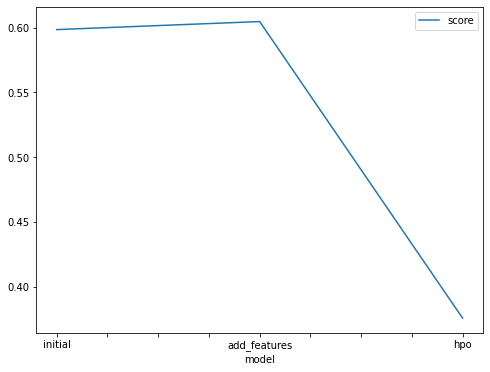

In [61]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
import pandas as pd
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [
          predictor.leaderboard(silent=True)['score_val'][0],
          predictor_new_features.leaderboard(silent=True)['score_val'][0],
          predictor_new_hpo.leaderboard(silent=True)['score_val'][0]
      ]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

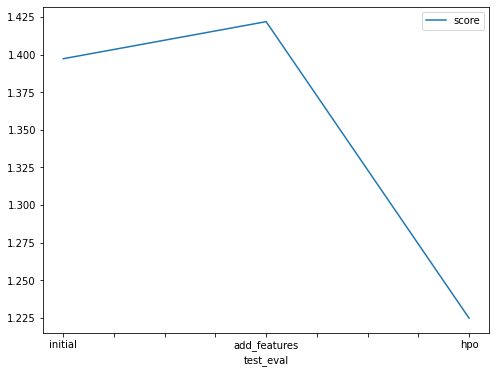

In [64]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.39725 , 1.42188 , 1.22490]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [63]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [600, 600, 1000],
    "hpo2": ["default", "default", "learning rate"],
    "hpo3": ["default", "default", "layers"],
    "score": [
          predictor.leaderboard(silent=True)['score_val'][0],
          predictor_new_features.leaderboard(silent=True)['score_val'][0],
          predictor_new_hpo.leaderboard(silent=True)['score_val'][0]
      ]
})

,model,hpo1,hpo2,hpo3,score
0,initial,600,default,default,0.598509
1,add_features,600,default,default,0.604720
2,hpo,1000,learning rate,layers,0.375633
